# Stadium Billiard Assignment — GIF Animations

This notebook generates and saves GIF animations for both the classical stadium billiard trajectory and the quantum wave packet evolution inside the stadium. The animations visually demonstrate chaotic dynamics and quantum evolution in the stadium geometry.

## 1. Generate and Save Stadium Billiard Trajectory GIF (Classical)

We animate the trajectory of a classical particle inside the stadium billiard using `matplotlib.animation.FuncAnimation`. The animation shows the particle bouncing off the boundaries, illustrating chaotic motion. The resulting GIF is saved for easy sharing and visualization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

# Stadium parameters
a = 1.0   # half-width of rectangle
b = 1.0   # half-height of rectangle
rx = 2.0  # ellipse semi-axis in x (caps)
ry = b    # ellipse semi-axis in y

# Simulate trajectory (reuse function from previous notebook)
def ellipse_quadratic_coeffs(x0, y0, vx, vy, cx):
    dx0 = x0 - cx
    A = (vx*vx)/(rx*rx) + (vy*vy)/(ry*ry)
    B = 2*(dx0*vx)/(rx*rx) + 2*(y0*vy)/(ry*ry)
    C = (dx0*dx0)/(rx*rx) + (y0*y0)/(ry*ry) - 1.0
    return A, B, C

def solve_quadratic(A, B, C):
    if abs(A) < 1e-18:
        if abs(B) < 1e-18:
            return []
        t = -C / B
        return [t] if np.isfinite(t) else []
    disc = B*B - 4*A*C
    if disc < 0:
        return []
    sqrt_d = np.sqrt(disc)
    t1 = (-B - sqrt_d) / (2*A)
    t2 = (-B + sqrt_d) / (2*A)
    roots = []
    for t in (t1, t2):
        if np.isfinite(t):
            roots.append(t)
    roots = sorted(set(roots))
    return roots

def ellipse_normal_at(x, y, cx):
    nx = (x - cx)/(rx*rx)
    ny = y/(ry*ry)
    v = np.array([nx, ny])
    norm = np.linalg.norm(v)
    if norm == 0:
        return np.array([1.0, 0.0])
    return v / norm

def reflect(v, n):
    return v - 2*np.dot(v, n)*n

def kinetic_energy(vx, vy, mass=1.0):
    return 0.5 * mass * (vx**2 + vy**2)

def simulate_trajectory(x0, y0, vx0, vy0, dt=0.01, steps=2000, max_bounces=None, eps_nudge=1e-9):
    x, y = float(x0), float(y0)
    vx, vy = float(vx0), float(vy0)
    X = [x]
    Y = [y]
    bounces = []
    bounce_count = 0
    for step in range(steps):
        remaining = dt
        while remaining > 1e-16:
            candidates = []
            if abs(vy) > 1e-16:
                for wall_y in (b, -b):
                    t = (wall_y - y)/vy
                    if t > 1e-15 and t <= remaining + 1e-15:
                        x_at = x + vx*t
                        if abs(x_at) <= a + 1e-12:
                            ny = 1.0 if wall_y > 0 else -1.0
                            if np.dot(np.array([vx, vy]), np.array([0.0, ny])) > 1e-12:
                                candidates.append((t, 1, 'hwall', wall_y, None))
            for sx in (1.0, -1.0):
                cx = sx * a
                A, B, C = ellipse_quadratic_coeffs(x, y, vx, vy, cx)
                roots = solve_quadratic(A, B, C)
                for t in roots:
                    if t > 1e-15 and t <= remaining + 1e-15:
                        x_at = x + vx*t
                        y_at = y + vy*t
                        if sx > 0 and x_at >= a - 1e-12:
                            n_ = ellipse_normal_at(x_at, y_at, cx)
                            if np.dot(np.array([vx, vy]), n_) > 1e-12:
                                candidates.append((t, 0, 'ellipse', cx, sx))
                        if sx < 0 and x_at <= -a + 1e-12:
                            n_ = ellipse_normal_at(x_at, y_at, cx)
                            if np.dot(np.array([vx, vy]), n_) > 1e-12:
                                candidates.append((t, 0, 'ellipse', cx, sx))
            if not candidates:
                x += vx * remaining
                y += vy * remaining
                remaining = 0.0
                break
            candidates.sort(key=lambda c: (c[0], c[1]))
            t_coll, _, kind, param, extra = candidates[0]
            x = x + vx * t_coll
            y = y + vy * t_coll
            if kind == 'hwall':
                ny = 1.0 if param > 0 else -1.0
                n = np.array([0.0, ny])
                v_ref = reflect(np.array([vx, vy]), n)
            else:
                cx = param
                n = ellipse_normal_at(x, y, cx)
                v_ref = reflect(np.array([vx, vy]), n)
            bounce_count += 1
            bounces.append((len(X), x, y, kind))
            v_ref = np.array(v_ref, dtype=float)
            speed = np.hypot(v_ref[0], v_ref[1])
            if speed > 0:
                v_ref = v_ref * (np.hypot(vx, vy) / speed)
            vx, vy = float(v_ref[0]), float(v_ref[1])
            vnorm = np.hypot(vx, vy)
            if vnorm > 0:
                x += (vx / vnorm) * eps_nudge
                y += (vy / vnorm) * eps_nudge
            remaining -= t_coll
            if max_bounces is not None and bounce_count >= max_bounces:
                remaining = 0.0
                break
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y), vx, vy, bounces

# Generate trajectory
X, Y, vx_final, vy_final, bounces = simulate_trajectory(0.0, 0.0, 1, 1, dt=0.01, steps=2000)

# Prepare stadium boundary for plotting
Xt = np.linspace(-a, a, 200)
Yt = np.full_like(Xt, b)
Xb_right = a + rx * np.cos(np.linspace(np.pi/2, -np.pi/2, 200))
Yb_right = ry * np.sin(np.linspace(np.pi/2, -np.pi/2, 200))
Xb_full = np.concatenate([Xt, Xb_right, Xt[::-1], -Xb_right[::-1]])
Yb_full = np.concatenate([Yt, Yb_right, -Yt, Yb_right[::-1]])

# Animation setup
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(Xb_full, Yb_full, 'k-', lw=1.2)
ax.set_aspect('equal')
ax.set_xlim(Xb_full.min()-0.2, Xb_full.max()+0.2)
ax.set_ylim(Yb_full.min()-0.2, Yb_full.max()+0.2)
ax.grid(True)
traj_line, = ax.plot([], [], '-b', lw=1.2)
particle, = ax.plot([], [], 'ro', markersize=8)
start_point, = ax.plot([X[0]], [Y[0]], 'go', markersize=8, label='start')
ax.legend()

def init():
    traj_line.set_data([], [])
    particle.set_data([], [])
    return traj_line, particle

def animate(i):
    traj_line.set_data(X[:i+1], Y[:i+1])
    particle.set_data(X[i], Y[i])
    return traj_line, particle

frames = len(X)
ani = animation.FuncAnimation(fig, animate, frames=frames, init_func=init, blit=True, interval=10)

# Save as GIF
ani.save('stadium_billiard_trajectory.gif', writer='pillow', fps=60)
plt.close(fig)
print("Classical stadium billiard trajectory GIF saved as 'stadium_billiard_trajectory.gif'.")

Classical stadium billiard trajectory GIF saved as 'stadium_billiard_trajectory.gif'.


## 2. Generate and Save Quantum Wave Packet Evolution GIF

We animate the evolution of the quantum probability density inside the stadium billiard using `matplotlib.animation.FuncAnimation`. The animation shows the spreading and reflection of the wave packet, illustrating quantum dynamics in a chaotic geometry. The GIF is saved for visualization.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

# Quantum parameters and grid (reuse from previous notebook)
hbar = 1.0
m = 1.0
Nx, Ny = 128, 128  # Use smaller grid for faster animation
dx = dy = 0.05
dt = 0.001
T_steps = 200  # Fewer steps for GIF
sigma = 0.2
x0, y0 = 0.0, 0.0
px, py = 2.0, 0

x = np.linspace(-a - rx, a + rx, Nx) * 1.2
y = np.linspace(-b - ry, b + ry, Ny) * 1.2
X, Y = np.meshgrid(x, y)

def stadium_mask(X, Y, a, b, rx, ry):
    rect = (np.abs(X) <= a) & (np.abs(Y) <= b)
    left_ellipse = ((X + a)**2 / rx**2 + Y**2 / ry**2 <= 1) & (X <= -a)
    right_ellipse = ((X - a)**2 / rx**2 + Y**2 / ry**2 <= 1) & (X >= a)
    return rect | left_ellipse | right_ellipse

mask = stadium_mask(X, Y, a, b, rx, ry)
V = 1e6 * (1 - mask)

# Momentum grid
kx = 2 * np.pi * np.fft.fftfreq(Nx, dx)
ky = 2 * np.pi * np.fft.fftfreq(Ny, dy)
KX, KY = np.meshgrid(kx, ky)
k2 = (KX**2 + KY**2) * hbar**2 / (2 * m)

# Initial Gaussian wave packet
psi = np.sqrt(1 / (np.pi * sigma**2)) * np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2) + 1j * (px * X + py * Y) / hbar)
psi *= mask
norm = np.sum(np.abs(psi)**2) * dx * dy
psi /= np.sqrt(norm)

def evolve_psi(psi, k2, dt, V):
    V_finite = np.where(np.isinf(V), 0, V)
    exp_factor = np.exp(-1j * V_finite * dt / (2 * hbar))
    psi = psi * exp_factor
    psi = np.where(np.isinf(V), 0, psi)
    psi_k = np.fft.fft2(psi)
    psi_k *= np.exp(-1j * k2 * dt / hbar)
    psi = np.fft.ifft2(psi_k)
    exp_factor = np.exp(-1j * V_finite * dt / (2 * hbar))
    psi = psi * exp_factor
    psi = np.where(np.isinf(V), 0, psi)
    return psi

# Evolve and store snapshots
psi_t = [psi.copy()]
for t in range(T_steps):
    psi = evolve_psi(psi, k2, dt, V)
    if t % 2 == 0:  # Store every 2nd frame for speed
        psi_t.append(psi.copy())

# Animation setup
fig, ax = plt.subplots(figsize=(7,6))
im = ax.imshow(np.abs(psi_t[0])**2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis', vmin=0, vmax=np.max(np.abs(psi_t[0])**2))
ax.set_title('Quantum Wave Packet Evolution')
ax.set_xlabel('x')
ax.set_ylabel('y')

def animate_q(i):
    im.set_data(np.abs(psi_t[i])**2)
    ax.set_title(f'Quantum Wave Packet Evolution (t={i*dt*2:.3f})')
    return [im]

ani_q = animation.FuncAnimation(fig, animate_q, frames=len(psi_t), blit=True, interval=50)

# Save as GIF
ani_q.save('stadium_quantum_wavepacket.gif', writer='pillow', fps=20)
plt.close(fig)
print("Quantum wave packet evolution GIF saved as 'stadium_quantum_wavepacket.gif'.")

Quantum wave packet evolution GIF saved as 'stadium_quantum_wavepacket.gif'.


In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
from math import isfinite

# Stadium parameters
# Rectangle: |x| <= a, |y| <= b
# Ellipse caps: centered at x=±a, semi-axes rx, ry

a = 3.0    # half-width of rectangle
b = 1.0   # half-height of rectangle
rx = 2.0  # ellipse semi-axis in x (caps)
ry = b    # ellipse semi-axis in y
EPS = 1e-9 # tolerance for floating-point comparisons

In [4]:
def ellipse_quadratic_coeffs(x0, y0, vx, vy, cx):
    # ellipse centered at (cx,0): ((x-cx)/rx)^2 + (y/ry)^2 = 1
    dx0 = x0 - cx
    A = (vx*vx)/(rx*rx) + (vy*vy)/(ry*ry)
    B = 2*(dx0*vx)/(rx*rx) + 2*(y0*vy)/(ry*ry)
    C = (dx0*dx0)/(rx*rx) + (y0*y0)/(ry*ry) - 1.0
    return A, B, C

def solve_quadratic(A, B, C):
    # robust quadratic solver for real roots; returns sorted positive roots list
    if abs(A) < 1e-18:
        if abs(B) < 1e-18:
            return []
        t = -C / B
        return [t] if isfinite(t) else []
    disc = B*B - 4*A*C
    if disc < 0:
        return []
    sqrt_d = np.sqrt(disc)
    t1 = (-B - sqrt_d) / (2*A)
    t2 = (-B + sqrt_d) / (2*A)
    roots = []
    for t in (t1, t2):
        if isfinite(t):
            roots.append(t)
    roots = sorted(set(roots))
    return roots

def ellipse_normal_at(x, y, cx):
    # gradient of F = (x-cx)^2/rx^2 + y^2/ry^2 - 1 gives normal ~ ((x-cx)/rx^2, y/ry^2)
    nx = (x - cx)/(rx*rx)
    ny = y/(ry*ry)
    v = np.array([nx, ny])
    norm = np.linalg.norm(v)
    if norm == 0:
        return np.array([1.0, 0.0])
    return v / norm

def reflect(v, n):
    # reflect velocity vector v about (unit) normal n
    return v - 2*np.dot(v, n)*n
def kinetic_energy(vx, vy, mass=1.0):
    """Return kinetic energy for given velocity components and mass (default 1)."""
    return 0.5 * mass * (vx**2 + vy**2)
    


In [5]:
import pandas as pd

def simulate_trajectory(x0, y0, vx0, vy0, dt=0.01, steps=10000, max_bounces=None, eps_nudge=1e-9):
    x, y = float(x0), float(y0)
    vx, vy = float(vx0), float(vy0)
    X = [x]
    Y = [y]
    bounces = []
    energy_records = []
    bounce_count = 0
    q = 0
    for step in range(steps):
        remaining = dt
        while remaining > 1e-16:
            candidates = []
            if abs(vy) > 1e-16:
                for wall_y in (b, -b):
                    t = (wall_y - y)/vy
                    if t > 1e-15 and t <= remaining + 1e-15:
                        x_at = x + vx*t
                        if abs(x_at) <= a + 1e-12:
                            ny = 1.0 if wall_y > 0 else -1.0
                            if np.dot(np.array([vx, vy]), np.array([0.0, ny])) > 1e-12:
                                candidates.append((t, 1, 'hwall', wall_y, None))
            for sx in (1.0, -1.0):
                cx = sx * a
                A, B, C = ellipse_quadratic_coeffs(x, y, vx, vy, cx)
                roots = solve_quadratic(A, B, C)
                for t in roots:
                    if t > 1e-15 and t <= remaining + 1e-15:
                        x_at = x + vx*t
                        y_at = y + vy*t
                        if sx > 0 and x_at >= a - 1e-12:
                            n_ = ellipse_normal_at(x_at, y_at, cx)
                            if np.dot(np.array([vx, vy]), n_) > 1e-12:
                                candidates.append((t, 0, 'ellipse', cx, sx))
                        if sx < 0 and x_at <= -a + 1e-12:
                            n_ = ellipse_normal_at(x_at, y_at, cx)
                            if np.dot(np.array([vx, vy]), n_) > 1e-12:
                                candidates.append((t, 0, 'ellipse', cx, sx))
            if not candidates:
                x += vx * remaining
                y += vy * remaining
                remaining = 0.0
                break
            candidates.sort(key=lambda c: (c[0], c[1]))
            t_coll, _, kind, param, extra = candidates[0]
            x = x + vx * t_coll
            y = y + vy * t_coll
            if kind == 'hwall':
                ny = 1.0 if param > 0 else -1.0
                n = np.array([0.0, ny])
                v_ref = reflect(np.array([vx, vy]), n)
            else:
                cx = param
                n = ellipse_normal_at(x, y, cx)
                v_ref = reflect(np.array([vx, vy]), n)
            bounce_count += 1
            bounces.append((len(X), x, y, kind))
            v_ref = np.array(v_ref, dtype=float)
            speed = np.hypot(v_ref[0], v_ref[1])
            if speed > 0:
                v_ref = v_ref * (np.hypot(vx, vy) / speed)
            vx, vy = float(v_ref[0]), float(v_ref[1])
            vnorm = np.hypot(vx, vy)
            if vnorm > 0:
                x += (vx / vnorm) * eps_nudge
                y += (vy / vnorm) * eps_nudge
            remaining -= t_coll
            # Record energy every 10 bounces
            if bounce_count % 10 == 0:
                energy = kinetic_energy(vx, vy)
                energy_records.append({'bounce': bounce_count, 'energy': energy})
            if max_bounces is not None and bounce_count >= max_bounces:
                remaining = 0.0
                break
        if bounce_count != 0 and (bounce_count) % 10 == 0 and q == 0:
            print(f'step {step}, bounces {bounce_count}, pos=({x:.3f},{y:.3f}), vel=({vx:.3f},{vy:.3f})')
            q = 1 
        elif (bounce_count) % 10 != 0 and q == 1:
            q = 0  
        X.append(x)
        Y.append(y)
    # Record energy at last bounce if not already recorded
    if len(bounces) > 0 and (len(energy_records) == 0 or energy_records[-1]['bounce'] != bounce_count):
        energy = kinetic_energy(vx, vy)
        energy_records.append({'bounce': bounce_count, 'energy': energy})
    return np.array(X), np.array(Y), vx, vy, bounces, energy_records
    

step 1741, bounces 10, pos=(-0.959,-1.000), vel=(1.005,0.995)
step 3578, bounces 20, pos=(-1.022,-0.994), vel=(1.056,0.940)
bounces recorded = 21
final velocity: 1.0561713155005683 -0.9404797458285841 speed: 1.4142135623730947


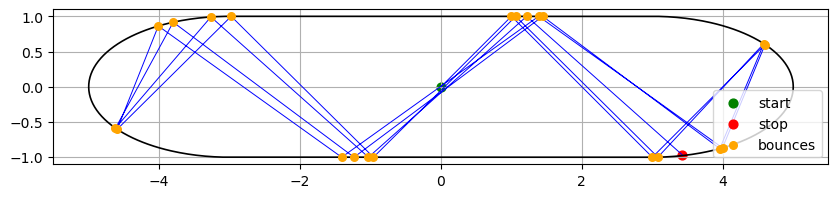

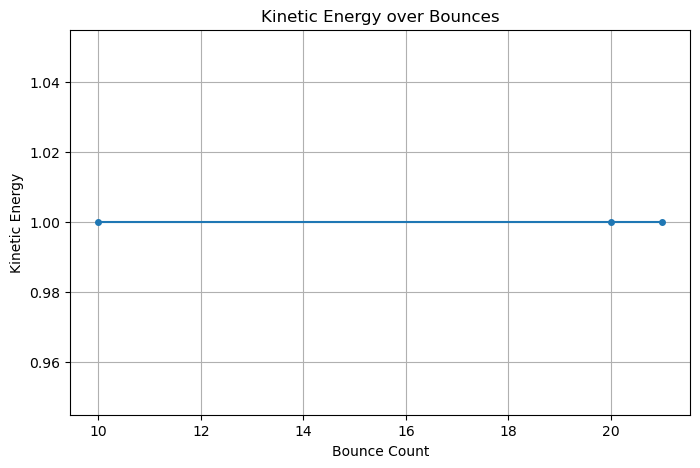

In [6]:
# Run and plot clean stadium billiard trajectory
X, Y, vx_final, vy_final, bounces, energy_records = simulate_trajectory(0.0, 0.0, 1, 1, dt=0.01, steps=4000, eps_nudge=1e-8)
print('bounces recorded =', len(bounces))
print('final velocity:', vx_final, vy_final, 'speed:', np.hypot(vx_final, vy_final))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(X, Y, '-b', lw=0.7)
ax.scatter([X[0]], [Y[0]], c='green', s=40, label='start')
ax.scatter([X[-1]], [Y[-1]], c='red', s=40, label='stop')
# Stadium boundary
Xt = np.linspace(-a, a, 200)
Yt = np.full_like(Xt, b)
Xb_right = a + rx * np.cos(np.linspace(np.pi/2, -np.pi/2, 200))
Yb_right = ry * np.sin(np.linspace(np.pi/2, -np.pi/2, 200))
Xb_full = np.concatenate([Xt, Xb_right, Xt[::-1], -Xb_right[::-1]])
Yb_full = np.concatenate([Yt, Yb_right, -Yt, Yb_right[::-1]])
ax.plot(Xb_full, Yb_full, 'k-', lw=1.2)
# Overlay bounces
if len(bounces) > 0:
    bx = [p[1] for p in bounces]
    by = [p[2] for p in bounces]
    ax.scatter(bx, by, c='orange', s=30, zorder=20, label='bounces')
ax.set_aspect('equal')
ax.grid(True)
ax.legend()
plt.savefig('stadium_billiard_clean.png', dpi=120)
plt.show()
#plot energy over bounces
if energy_records:
    energy_table = pd.DataFrame(energy_records)
    plt.figure(figsize=(8,5))
    plt.plot(energy_table['bounce'], energy_table['energy'], '-o', markersize=4)
    plt.xlabel('Bounce Count')
    plt.ylabel('Kinetic Energy')
    plt.title('Kinetic Energy over Bounces')
    plt.grid(True)
    plt.savefig('kinetic_energy_over_bounces.png', dpi=120)
    plt.show()
    


step 1741, bounces 10, pos=(-0.959,-1.000), vel=(1.005,0.995)
step 3578, bounces 20, pos=(-1.022,-0.994), vel=(1.056,0.940)
step 5412, bounces 30, pos=(-1.132,-0.995), vel=(1.111,0.875)
step 7244, bounces 40, pos=(-1.275,-0.992), vel=(1.145,0.830)
step 9073, bounces 50, pos=(-1.462,-0.998), vel=(1.128,0.853)
step 10923, bounces 60, pos=(-1.285,-0.992), vel=(1.073,0.921)
step 12774, bounces 70, pos=(-1.074,-0.992), vel=(1.006,0.994)
step 14618, bounces 80, pos=(-0.992,-0.993), vel=(1.015,0.984)
step 16456, bounces 90, pos=(-1.031,-0.992), vel=(1.053,0.944)
step 18291, bounces 100, pos=(-1.121,-0.994), vel=(1.103,0.886)
step 20123, bounces 110, pos=(-1.262,-0.995), vel=(1.134,0.845)
step 21959, bounces 120, pos=(-1.333,-0.993), vel=(1.150,0.823)
step 23789, bounces 130, pos=(-1.502,-1.000), vel=(1.104,0.884)
step 25651, bounces 140, pos=(-1.095,-0.996), vel=(0.977,1.023)
step 27392, bounces 150, pos=(-2.856,-0.990), vel=(0.941,1.056)
step 29131, bounces 160, pos=(-3.588,-0.955), vel=(-0.

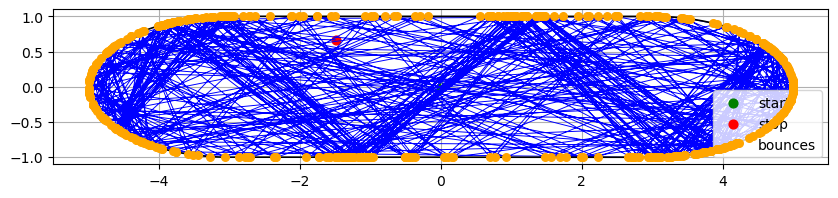

Energy conserved!
    bounce  energy
0       10     1.0
1       20     1.0
2       30     1.0
3       40     1.0
4       50     1.0
5       60     1.0
6       70     1.0
7       80     1.0
8       90     1.0
9      100     1.0
10     110     1.0
11     120     1.0
12     130     1.0
13     140     1.0
14     150     1.0
15     160     1.0
16     170     1.0
17     180     1.0
18     190     1.0
19     200     1.0
20     210     1.0
21     220     1.0
22     230     1.0
23     240     1.0
24     250     1.0
25     260     1.0
26     270     1.0
27     280     1.0
28     290     1.0
29     300     1.0
30     310     1.0
31     320     1.0
32     330     1.0
33     340     1.0
34     350     1.0
35     360     1.0
36     370     1.0
37     380     1.0
38     390     1.0
39     400     1.0
40     410     1.0
41     420     1.0
42     430     1.0
43     440     1.0
44     450     1.0
45     460     1.0
46     470     1.0
47     473     1.0


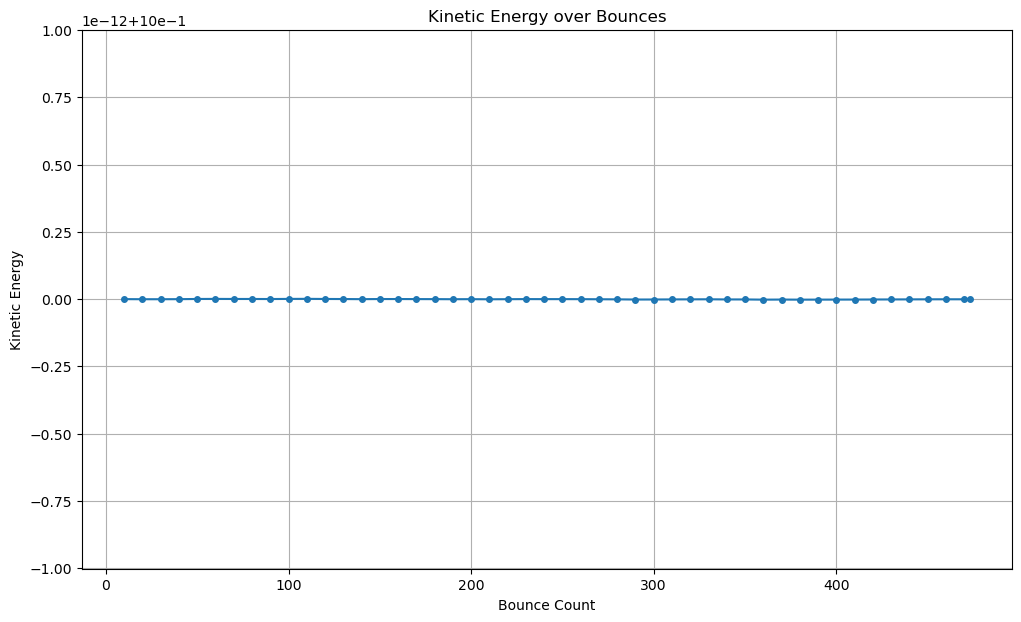

In [7]:
# Run and plot clean stadium billiard trajectory
X, Y, vx_final, vy_final, bounces, energy_records = simulate_trajectory(0.0, 0.0, 1, 1, dt=0.01, steps=100000, eps_nudge=1e-8)
print('bounces recorded =', len(bounces))
print('final velocity:', vx_final, vy_final, 'speed:', np.hypot(vx_final, vy_final))
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(X, Y, '-b', lw=0.7)
ax.scatter([X[0]], [Y[0]], c='green', s=40, label='start')
ax.scatter([X[-1]], [Y[-1]], c='red', s=40, label='stop')
# Stadium boundary
Xt = np.linspace(-a, a, 200)
Yt = np.full_like(Xt, b)
Xb_right = a + rx * np.cos(np.linspace(np.pi/2, -np.pi/2, 200))
Yb_right = ry * np.sin(np.linspace(np.pi/2, -np.pi/2, 200))
Xb_full = np.concatenate([Xt, Xb_right, Xt[::-1], -Xb_right[::-1]])
Yb_full = np.concatenate([Yt, Yb_right, -Yt, Yb_right[::-1]])
ax.plot(Xb_full, Yb_full, 'k-', lw=1.2)
# Overlay bounces
if len(bounces) > 0:
    bx = [p[1] for p in bounces]
    by = [p[2] for p in bounces]
    ax.scatter(bx, by, c='orange', s=30, zorder=20, label='bounces')
ax.set_aspect('equal')
ax.grid(True)
ax.legend()
plt.savefig('stadium_billiard_clean1.png', dpi=120)
plt.show()
#plot energy over bounces
#convert to integer energy records

if energy_records:
    energy_table = pd.DataFrame(energy_records)
    if np.allclose(energy_table['energy'], 1.0, atol=1e-8):
        print("Energy conserved!")
    else:
        print("Energy not conserved!")

    plt.figure(figsize=(12,7))
    plt.plot(energy_table['bounce'], energy_table['energy'], '-o', markersize=4)
    print(energy_table)
    plt.xlabel('Bounce Count')
    plt.ylabel('Kinetic Energy')
    plt.title('Kinetic Energy over Bounces')
    plt.grid(True)
    plt.savefig('kinetic_energy_over_bounces1.png', dpi=120)
    plt.show()



In [21]:
# Classical stadium billiard trajectory GIF with 8x speed
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

# Use the same stadium parameters as above
a = 1.0
b = 1.0
rx = 2.0
ry = b

# Simulate trajectory with 8x speed
X, Y, vx_final, vy_final, bounces, energy_records = simulate_trajectory(-0.5, 0.3, -15, 35, dt=0.001, steps=2000)

# Prepare stadium boundary for plotting
Xt = np.linspace(-a, a, 200)
Yt = np.full_like(Xt, b)
Xb_right = a + rx * np.cos(np.linspace(np.pi/2, -np.pi/2, 200))
Yb_right = ry * np.sin(np.linspace(np.pi/2, -np.pi/2, 200))
Xb_full = np.concatenate([Xt, Xb_right, Xt[::-1], -Xb_right[::-1]])
Yb_full = np.concatenate([Yt, Yb_right, -Yt, Yb_right[::-1]])

# Animation setup
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(Xb_full, Yb_full, 'k-', lw=1.2)
ax.set_aspect('equal')
ax.set_xlim(Xb_full.min()-0.2, Xb_full.max()+0.2)
ax.set_ylim(Yb_full.min()-0.2, Yb_full.max()+0.2)
ax.grid(True)
traj_line, = ax.plot([], [], '-b', lw=1.2)
particle, = ax.plot([], [], 'ro', markersize=8)
start_point, = ax.plot([X[0]], [Y[0]], 'go', markersize=8, label='start')
ax.legend()

def init():
    traj_line.set_data([], [])
    particle.set_data([], [])
    return traj_line, particle

def animate(i):
    traj_line.set_data(X[:i+1], Y[:i+1])
    particle.set_data(X[i], Y[i])
    return traj_line, particle

frames = len(X)
ani = animation.FuncAnimation(fig, animate, frames=frames, init_func=init, blit=True, interval=35)

# Save as GIF
ani.save('stadium_bounce_8x.gif', writer='pillow', fps=20)
plt.close(fig)
print("Classical stadium billiard trajectory GIF (8x speed) saved as 'stadium_bounce_8x.gif'.")

step 506, bounces 10, pos=(0.577,-0.986), vel=(-14.399,35.252)
step 1051, bounces 20, pos=(0.956,-0.991), vel=(-14.817,35.078)
step 1596, bounces 30, pos=(1.459,-0.950), vel=(-14.600,35.169)


Classical stadium billiard trajectory GIF (8x speed) saved as 'stadium_bounce_8x.gif'.
